In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
# carregando a base de cadastro
cadastros = pd.read_csv(r'https://github.com/alura-tech/alura-tech-pos-data-science-credit-scoring-streamlit/blob/main/dados/clientes_cadastrados.csv?raw=True')

In [96]:
cadastros.head(3)

,ID_Cliente,Genero,Tem_carro,Tem_casa_propria,Qtd_filhos,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Idade,Anos_empregado,Tem_celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_familia
0,5008804,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Empregado,Ensino superior,União-estável,Apartamento alugado,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,-21474,-1134,1,0,0,0,Segurança,2.0


In [97]:
# tamanho do df
cadastros.shape

(438557, 18)

In [98]:
# verificando dados nulos
id_rep = cadastros[cadastros['ID_Cliente'].duplicated(keep=False)]
df_cadastro = cadastros.drop(id_rep.index)

In [99]:
# verificando dados nulos
df_cadastro.isnull().sum()

ID_Cliente                    0
Genero                        0
Tem_carro                     0
Tem_casa_propria              0
Qtd_filhos                    0
Rendimento_anual              0
Categoria_de_renda            0
Grau_escolaridade             0
Estado_civil                  0
Moradia                       0
Idade                         0
Anos_empregado                0
Tem_celular                   0
Tem_telefone_trabalho         0
Tem_telefone_fixo             0
Tem_email                     0
Ocupacao                 134177
Tamanho_familia               0
dtype: int64

In [100]:
# verificando os dados na coluna que tem valores vazios
df_cadastro['Ocupacao'].unique()

array([nan, 'Segurança', 'Vendas', 'Contabilidade', 'Construção Civil',
       'Gerência', 'Motorista', 'Equipe principal', 'Alta tecnologia',
       'Limpeza', 'Serviço privado', 'Cozinha', 'Baixa qualificação',
       'Medicina', 'Secretariado', 'Garçom', 'RH', 'Corretor imobiliário',
       'TI'], dtype=object)

In [101]:
# substituindo os vazios por 'outros'
df_cadastro['Ocupacao'].fillna(value='Outros', inplace=True)

In [102]:
# verificando quantidade de valores distintos por coluna
df_cadastro.nunique()

ID_Cliente               438463
Genero                        2
Tem_carro                     2
Tem_casa_propria              2
Qtd_filhos                   12
Rendimento_anual            866
Categoria_de_renda            5
Grau_escolaridade             5
Estado_civil                  5
Moradia                       6
Idade                     16379
Anos_empregado             9406
Tem_celular                   1
Tem_telefone_trabalho         2
Tem_telefone_fixo             2
Tem_email                     2
Ocupacao                     19
Tamanho_familia              13
dtype: int64

In [103]:
# tratamento de colunas
df_cadastro = df_cadastro.assign(
                                Tem_carro = np.where(df_cadastro['Tem_carro'] == 'Y', 1, 0),
                                Tem_casa_propria = np.where(df_cadastro['Tem_casa_propria'] == 'Y', 1, 0),
                                Idade = - (df_cadastro['Idade']/365.2425),
                                Anos_empregado=lambda x: np.where(-(x['Anos_empregado'] / 365.2425) < 0,
                                                                  0, 
                                                                  -(x['Anos_empregado'] / 365.2425))
                                                                  )

In [104]:
# removendo colunas
df_cadastro.drop(columns=['Genero', 'Tem_celular'], inplace=True)

In [105]:
# verificando tipo de dados
df_cadastro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438463 entries, 0 to 438556
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_Cliente             438463 non-null  int64  
 1   Tem_carro              438463 non-null  int32  
 2   Tem_casa_propria       438463 non-null  int32  
 3   Qtd_filhos             438463 non-null  int64  
 4   Rendimento_anual       438463 non-null  float64
 5   Categoria_de_renda     438463 non-null  object 
 6   Grau_escolaridade      438463 non-null  object 
 7   Estado_civil           438463 non-null  object 
 8   Moradia                438463 non-null  object 
 9   Idade                  438463 non-null  float64
 10  Anos_empregado         438463 non-null  float64
 11  Tem_telefone_trabalho  438463 non-null  int64  
 12  Tem_telefone_fixo      438463 non-null  int64  
 13  Tem_email              438463 non-null  int64  
 14  Ocupacao               438463 non-null  o

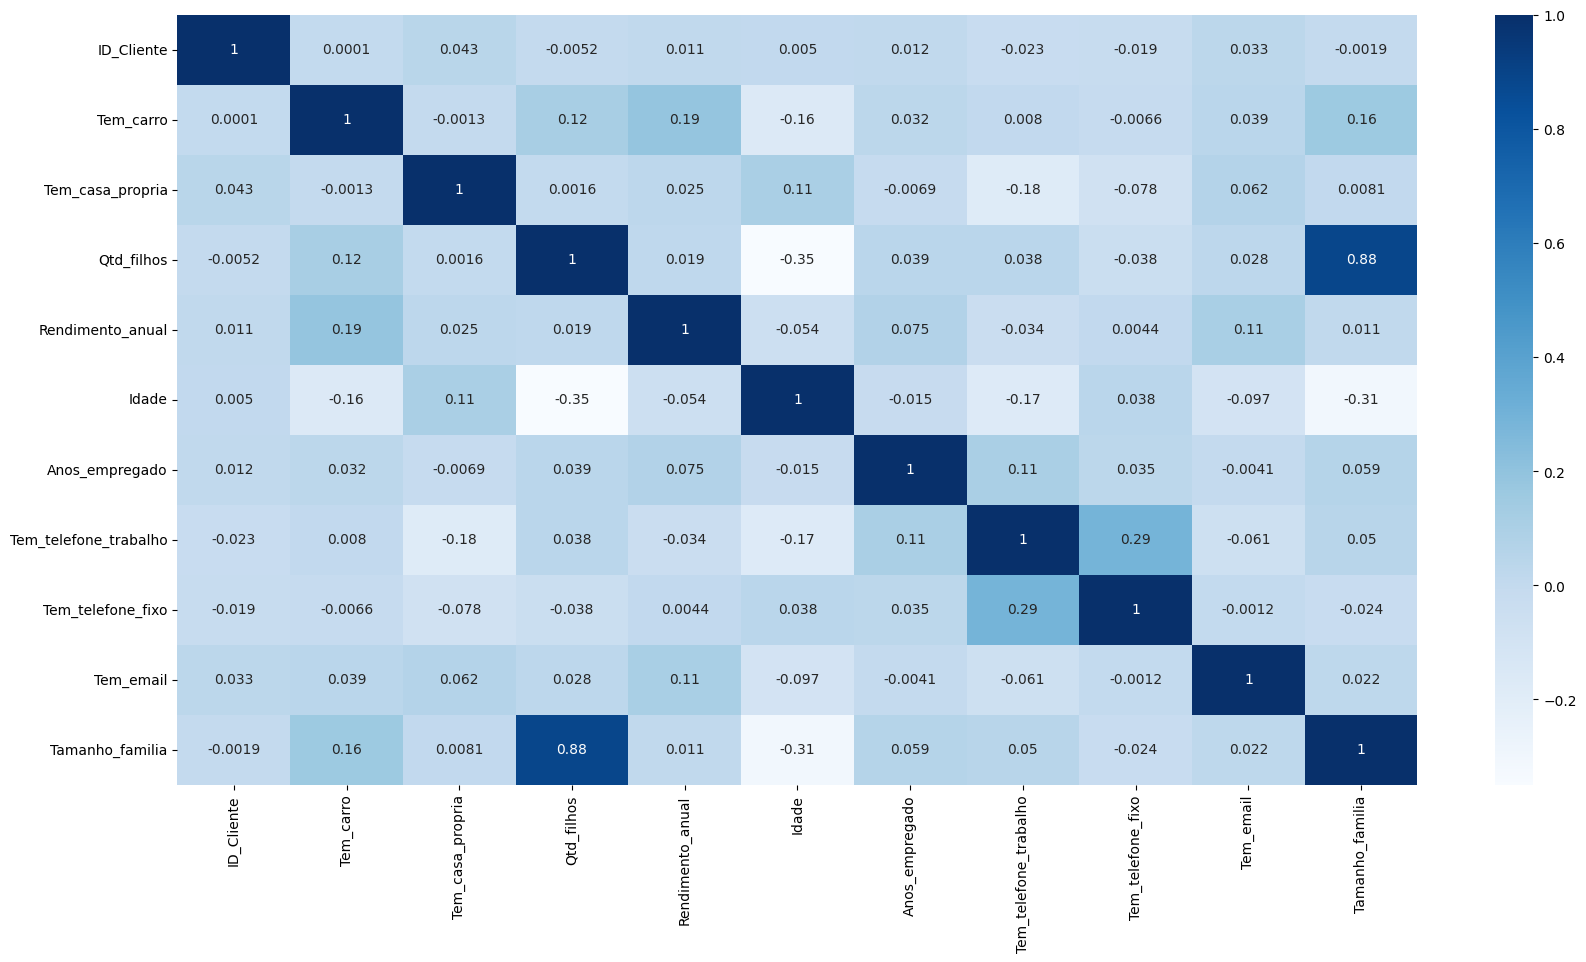

In [106]:
# analisando as correlacoes
numeric_df = df_cadastro.select_dtypes(include=['number'])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(corr, cmap='Blues', annot=True)

In [107]:
# removendo colunas
df_cadastro.drop(columns=['Qtd_filhos'], inplace=True)

In [108]:
df_cadastro.columns

Index(['ID_Cliente', 'Tem_carro', 'Tem_casa_propria', 'Rendimento_anual',
       'Categoria_de_renda', 'Grau_escolaridade', 'Estado_civil', 'Moradia',
       'Idade', 'Anos_empregado', 'Tem_telefone_trabalho', 'Tem_telefone_fixo',
       'Tem_email', 'Ocupacao', 'Tamanho_familia'],
      dtype='object')

In [109]:
# reeordenando as colunas
df_cadastro = df_cadastro[['ID_Cliente', 'Tem_carro', 'Tem_casa_propria', 'Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
                           'Tamanho_familia', 'Rendimento_anual', 'Idade', 'Anos_empregado', 'Categoria_de_renda', 'Grau_escolaridade', 'Estado_civil', 'Moradia', 'Ocupacao']]

<Axes: xlabel='Categoria_de_renda'>

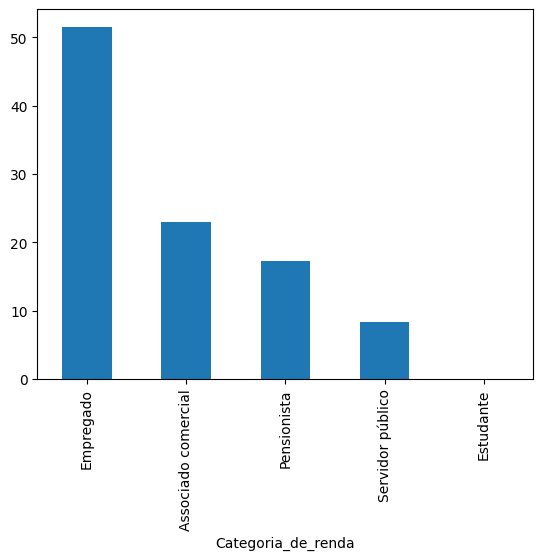

In [110]:
(df_cadastro.Categoria_de_renda.value_counts(normalize=True)*100).plot(kind='bar', )

In [138]:
# carregando base de aprovados
aprovados = pd.read_csv('https://github.com/alura-tech/alura-tech-pos-data-science-credit-scoring-streamlit/blob/main/dados/clientes_aprovados.csv?raw=True')  

In [139]:
# verificando as informacoes
aprovados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID_Cliente      1048575 non-null  int64 
 1   Mes_referencia  1048575 non-null  int64 
 2   Faixa_atraso    1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [140]:
aprovados.head(3)

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias


In [114]:
aprovados.query('ID_Cliente == 5001712')

,ID_Cliente,Mes_referencia,Faixa_atraso
4,5001712,0,pagamento realizado
5,5001712,-1,pagamento realizado
6,5001712,-2,pagamento realizado
7,5001712,-3,pagamento realizado
8,5001712,-4,pagamento realizado
9,5001712,-5,pagamento realizado
10,5001712,-6,pagamento realizado
11,5001712,-7,pagamento realizado
12,5001712,-8,pagamento realizado
13,5001712,-9,1-29 dias


In [141]:
# frequencia por faixa de atraso
aprovados.Faixa_atraso.value_counts()

Faixa_atraso
pagamento realizado    442031
1-29 dias              383120
nenhum empréstimo      209230
30-59 dias              11090
>150 dias                1693
60-89 dias                868
90-119 dias               320
120-149 dias              223
Name: count, dtype: int64

In [116]:
aprovados.Faixa_atraso.unique()

array(['nenhum empréstimo', '1-29 dias', 'pagamento realizado',
       '30-59 dias', '60-89 dias', '90-119 dias', '120-149 dias',
       '>150 dias'], dtype=object)

In [117]:
# criando df com ref de cadastro e ref mais recente
mes_ref = aprovados.groupby('ID_Cliente').agg(Abertura=('Mes_referencia', 'min'), Final=('Mes_referencia', 'max')).reset_index()

# acrescentando informacoes de refs
df_aprovados = pd.merge(
                    aprovados,
                    mes_ref,
                    on='ID_Cliente',
                    how='inner'
                )

# dicionario com id de faixa de atraso
dict_faixa_atraso_id = {'nenhum empréstimo':0, 'pagamento realizado':1, '1-29 dias':2,
                        '30-59 dias':3, '60-89 dias':4, '90-119 dias':5, '120-149 dias':6,
                        '>150 dias':7
                        }

# tratamento de colunas
df_aprovados = df_aprovados.assign(
                                    Janela=df_aprovados['Final'] - df_aprovados['Abertura'],
                                    MOB = df_aprovados['Mes_referencia'] - df_aprovados['Abertura'],
                                    id_faixa_atraso = df_aprovados['Faixa_atraso'].map(dict_faixa_atraso_id),
                                    mau_pagador=lambda x: x['id_faixa_atraso'].apply(lambda x: 1 if x > 3 else 0)
                                )

In [119]:
# o df tem mais de um vou filtrar apenas informaçoes de refs importantes
df_registros_creditos_ID = df_aprovados[['ID_Cliente','Abertura', 'Final', 'Janela']].groupby('ID_Cliente').apply(lambda x: x.iloc[0]).reset_index(drop=True)
df_registros_creditos_ID

,ID_Cliente,Abertura,Final,Janela
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [123]:
# Quantida de clientes por tempo de cadastro
df_denominador = df_registros_creditos_ID.groupby('Abertura').apply(lambda x: x['ID_Cliente'].count()).reset_index(name='Qtd_Clientes')
df_denominador

,Abertura,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [124]:
# quantidade de clientes por abertura e MOB
df_vintage = df_aprovados.groupby(['Abertura', 'MOB']).apply(lambda x: x['ID_Cliente'].count()).reset_index(name='Qtd_Clientes')
df_vintage = pd.merge(df_vintage[['Abertura', 'MOB']],
                      df_denominador,
                      on='Abertura',
                      how='left')
df_vintage

,Abertura,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [132]:
# verificando quantidade de maus pagadores por tempo de abertura e MOB
df_denominador['Qtd_Mau'] = np.nan

for j in range(-60, 1):
    ls = []
    for i in range(0,61):
        due = list(df_aprovados.query('mau_pagador == 1 and MOB ==@i and Abertura ==@j')['ID_Cliente'])
        ls.extend(due)
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Abertura'] == j), 'Qtd_Mau'] = len(set(ls))

df_vintage['Taxa_de_Mau'] = df_vintage['Qtd_Mau'] / df_vintage['Qtd_Clientes']
df_vintage

,Abertura,MOB,Qtd_Clientes,Qtd_Mau,Taxa_de_Mau
0,-60,0,415,0.0,0.000000
1,-60,1,415,0.0,0.000000
2,-60,2,415,0.0,0.000000
3,-60,3,415,0.0,0.000000
4,-60,4,415,0.0,0.000000
...,...,...,...,...,...
1886,-2,1,771,0.0,0.000000
1887,-2,2,771,1.0,0.001297
1888,-1,0,686,0.0,0.000000
1889,-1,1,686,0.0,0.000000


In [134]:
df_vintage_pivot = df_vintage.pivot(
                                    index='Abertura',
                                    columns='MOB',
                                    values='Taxa_de_Mau'
                                    )
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Abertura,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.003432,0.003432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


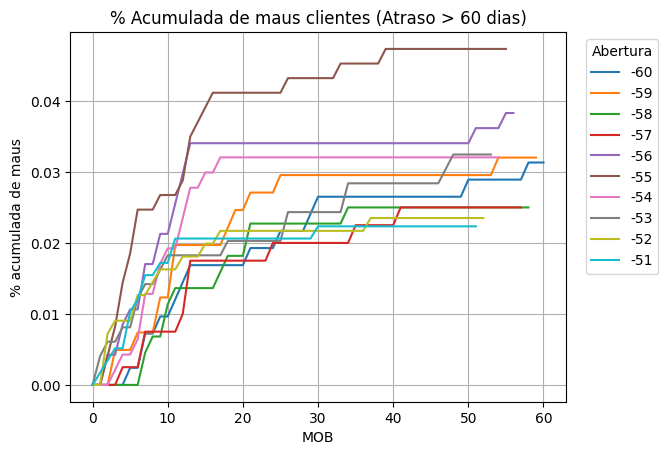

In [135]:
lst = [i for i in range(0,61)]
df_vintage_pivot[lst].T.iloc[:, :10].plot(
                                        legend=True,
                                        grid=True,
                                        title='% Acumulada de maus clientes (Atraso > 60 dias)'
                                    )

plt.xlabel('MOB')
plt.ylabel('% acumulada de maus')
plt.legend(bbox_to_anchor=(1.2, 1), title='Abertura')
plt.show()

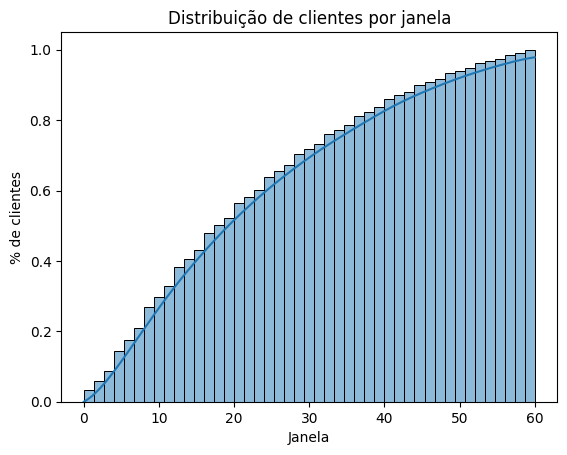

In [149]:
sns.histplot(data=df_registros_creditos_ID, x='Janela', cumulative=True, stat='density', kde=True)
plt.title('Distribuição de clientes por janela')
plt.xlabel('Janela')
plt.ylabel('% de clientes')
plt.show()